## Topic:
#### How does the sentiment of social media posts affect the stocks market

In [53]:
## Load Packages
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
import string
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
import re
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer


In [54]:
df = pd.read_excel('stock_data.xlsx')
df.head(10)

,Year,Company,Corpus
0,2018,Amazon,I'm excited to see Amazon's new headquarters i...
1,2015,Apple,I'm so disappointed in Apple's new product lin...
2,2017,Tesla,Just bought some Tesla stock and I'm feeling r...
3,2019,Netflix,Just finished binge-watching the latest Netfli...
4,2016,Facebook,I'm loving all the new features on Facebook. I...
5,2017,Amazon,I'm so frustrated with Amazon's shipping polic...
6,2019,Tesla,I can't believe how poorly Tesla is doing. The...
7,2020,Apple,I'm really impressed with Apple's new iPhone l...
8,2018,Netflix,I just watched a documentary on Netflix that w...
9,2016,Facebook,I'm getting really tired of all the political ...


## Data Cleaning and Preprocessing


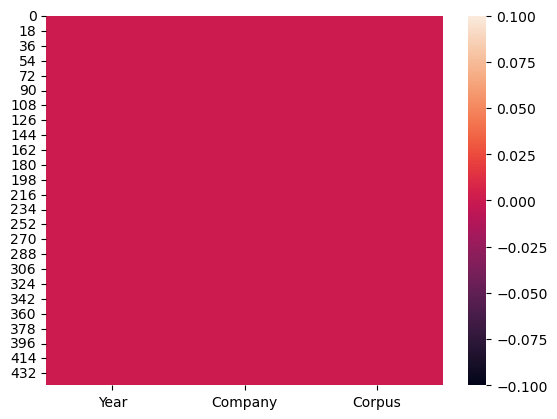

In [55]:
sns.heatmap(df.isnull());

#### Length of the text in the data used

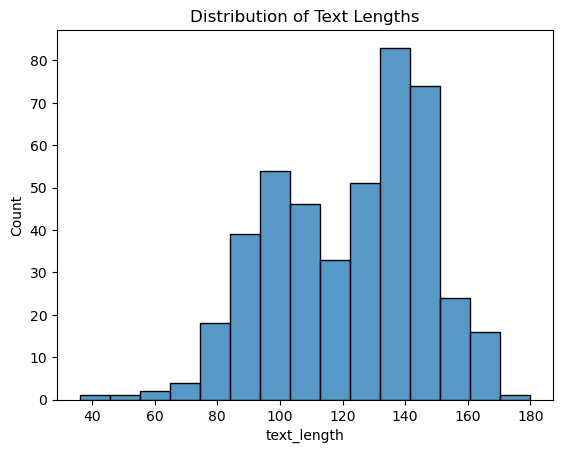

In [56]:
df['text_length'] = df['Corpus'].apply(len)
sns.histplot(x='text_length', data=df)
plt.title('Distribution of Text Lengths')
plt.show()

In [57]:
# convert to lowercase
df['Corpus'] = df['Corpus'].apply(lambda x: x.lower()) 

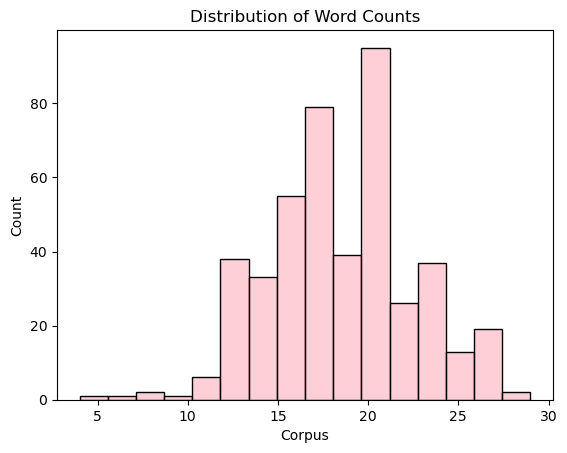

In [58]:
word_count = df['Corpus'].apply(lambda x: len(x.split()))
sns.histplot(word_count,color = 'pink')
plt.title('Distribution of Word Counts')
plt.show()

In [59]:
regexp = RegexpTokenizer('\w+')
df['Corpus_token']=df['Corpus'].apply(regexp.tokenize)
df.head(3)

,Year,Company,Corpus,text_length,Corpus_token
0,2018,Amazon,i'm excited to see amazon's new headquarters i...,141,"[i, m, excited, to, see, amazon, s, new, headq..."
1,2015,Apple,i'm so disappointed in apple's new product lin...,125,"[i, m, so, disappointed, in, apple, s, new, pr..."
2,2017,Tesla,just bought some tesla stock and i'm feeling r...,139,"[just, bought, some, tesla, stock, and, i, m, ..."


In [60]:
df['Corpus_token']

0      [i, m, excited, to, see, amazon, s, new, headq...
1      [i, m, so, disappointed, in, apple, s, new, pr...
2      [just, bought, some, tesla, stock, and, i, m, ...
3      [just, finished, binge, watching, the, latest,...
4      [i, m, loving, all, the, new, features, on, fa...
                             ...                        
442    [i, appreciate, apple, s, commitment, to, acce...
443    [the, apple, podcasts, app, has, a, wide, rang...
444    [the, seamless, integration, of, icloud, acros...
445    [apple, s, commitment, to, product, security, ...
446    [the, apple, watch, s, ability, to, track, my,...
Name: Corpus_token, Length: 447, dtype: object

In [61]:
stopwords = nltk.corpus.stopwords.words("english")
# Extend the list with your own custom stopwords
my_stopwords = ['https']
stopwords.extend(my_stopwords)
# Remove stopwords
df['Corpus_token'] = df['Corpus_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head(3)

,Year,Company,Corpus,text_length,Corpus_token
0,2018,Amazon,i'm excited to see amazon's new headquarters i...,141,"[excited, see, amazon, new, headquarters, virg..."
1,2015,Apple,i'm so disappointed in apple's new product lin...,125,"[disappointed, apple, new, product, lineup, us..."
2,2017,Tesla,just bought some tesla stock and i'm feeling r...,139,"[bought, tesla, stock, feeling, really, good, ..."


In [62]:
df['Corpus_string'] = df['Corpus_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df[['Corpus', 'Corpus_token', 'Corpus_string']].head()

,Corpus,Corpus_token,Corpus_string
0,i'm excited to see amazon's new headquarters i...,"[excited, see, amazon, new, headquarters, virg...",excited see amazon new headquarters virginia t...
1,i'm so disappointed in apple's new product lin...,"[disappointed, apple, new, product, lineup, us...",disappointed apple new product lineup used inn...
2,just bought some tesla stock and i'm feeling r...,"[bought, tesla, stock, feeling, really, good, ...",bought tesla stock feeling really good think e...
3,just finished binge-watching the latest netfli...,"[finished, binge, watching, latest, netflix, s...",finished binge watching latest netflix series ...
4,i'm loving all the new features on facebook. i...,"[loving, new, features, facebook, great, way, ...",loving new features facebook great way stay co...


In [63]:
all_words = ' '.join([word for word in df['Corpus_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [64]:
fdist = FreqDist(tokenized_words)
fdist

FreqDist({'apple': 182, 'investing': 79, 'stocks': 73, 'new': 40, 'quality': 28, 'commitment': 27, 'future': 26, 'electric': 25, 'iphone': 23, 'always': 23, ...})

In [65]:
df['Corpus_string_fdist'] = df['Corpus_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
df[['Corpus', 'Corpus_token', 'Corpus_string', 'Corpus_string_fdist']].head()

,Corpus,Corpus_token,Corpus_string,Corpus_string_fdist
0,i'm excited to see amazon's new headquarters i...,"[excited, see, amazon, new, headquarters, virg...",excited see amazon new headquarters virginia t...,excited see amazon new headquarters virginia t...
1,i'm so disappointed in apple's new product lin...,"[disappointed, apple, new, product, lineup, us...",disappointed apple new product lineup used inn...,disappointed apple new product lineup used inn...
2,just bought some tesla stock and i'm feeling r...,"[bought, tesla, stock, feeling, really, good, ...",bought tesla stock feeling really good think e...,bought tesla stock feeling really good think e...
3,just finished binge-watching the latest netfli...,"[finished, binge, watching, latest, netflix, s...",finished binge watching latest netflix series ...,finished binge watching latest netflix series ...
4,i'm loving all the new features on facebook. i...,"[loving, new, features, facebook, great, way, ...",loving new features facebook great way stay co...,loving new features facebook great way stay co...


In [66]:
wordnet_lem = WordNetLemmatizer()
df['Corpus_string_lem'] = df['Corpus_string_fdist'].apply(wordnet_lem.lemmatize)

In [67]:
df['is_equal']= (df['Corpus_string_fdist']==df['Corpus_string_lem'])
# show level count
df.is_equal.value_counts()
df

,Year,Company,Corpus,text_length,Corpus_token,Corpus_string,Corpus_string_fdist,Corpus_string_lem,is_equal
0,2018,Amazon,i'm excited to see amazon's new headquarters i...,141,"[excited, see, amazon, new, headquarters, virg...",excited see amazon new headquarters virginia t...,excited see amazon new headquarters virginia t...,excited see amazon new headquarters virginia t...,True
1,2015,Apple,i'm so disappointed in apple's new product lin...,125,"[disappointed, apple, new, product, lineup, us...",disappointed apple new product lineup used inn...,disappointed apple new product lineup used inn...,disappointed apple new product lineup used inn...,True
2,2017,Tesla,just bought some tesla stock and i'm feeling r...,139,"[bought, tesla, stock, feeling, really, good, ...",bought tesla stock feeling really good think e...,bought tesla stock feeling really good think e...,bought tesla stock feeling really good think e...,True
3,2019,Netflix,just finished binge-watching the latest netfli...,114,"[finished, binge, watching, latest, netflix, s...",finished binge watching latest netflix series ...,finished binge watching latest netflix series ...,finished binge watching latest netflix series ...,True
4,2016,Facebook,i'm loving all the new features on facebook. i...,109,"[loving, new, features, facebook, great, way, ...",loving new features facebook great way stay co...,loving new features facebook great way stay co...,loving new features facebook great way stay co...,True
...,...,...,...,...,...,...,...,...,...
442,2022,Apple,i appreciate apple's commitment to accessibili...,151,"[appreciate, apple, commitment, accessibility,...",appreciate apple commitment accessibility feat...,appreciate apple commitment accessibility feat...,appreciate apple commitment accessibility feat...,True
443,2022,Apple,the apple podcasts app has a wide range of pod...,164,"[apple, podcasts, app, wide, range, podcasts, ...",apple podcasts app wide range podcasts various...,apple podcasts app wide range podcasts various...,apple podcasts app wide range podcasts various...,True
444,2022,Apple,the seamless integration of icloud across my d...,124,"[seamless, integration, icloud, across, device...",seamless integration icloud across devices mak...,seamless integration icloud across devices mak...,seamless integration icloud across devices mak...,True
445,2022,Apple,apple's commitment to product security is comm...,161,"[apple, commitment, product, security, commend...",apple commitment product security commendable ...,apple commitment product security commendable ...,apple commitment product security commendable ...,True


In [68]:
all_words_lem = ' '.join([word for word in df['Corpus_string_lem']])

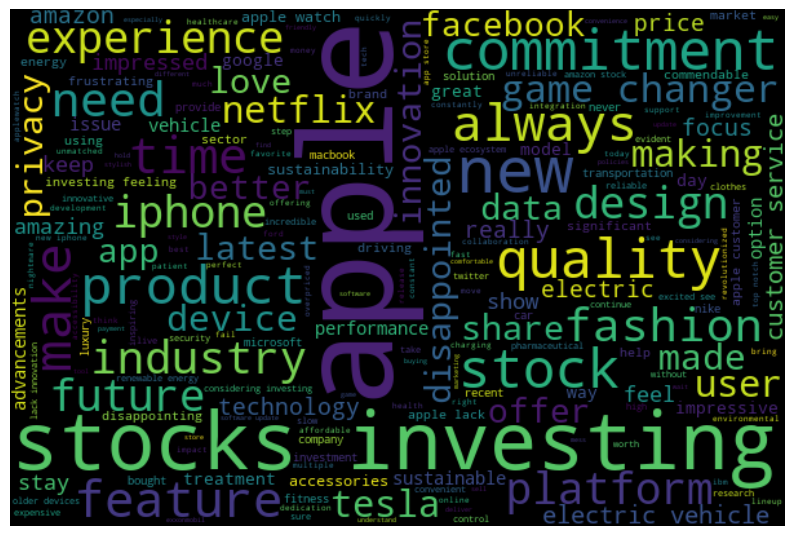

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [70]:
words = nltk.word_tokenize(all_words_lem)
fd = FreqDist(words)

In [71]:
fd.most_common(3)
fd.tabulate(3)

    apple investing    stocks 
      182        79        73 


In [72]:
##Plot common words
# Obtain top 10 words
top_10 = fd.most_common(10)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))

In [73]:
import plotly.express as px
fig = px.bar(y=fdist.index, x=fdist.values)
# sort values
fig.update_layout(barmode='stack', title = 'Frequency of words', yaxis={'categoryorder':'total ascending'})
# show plot
fig.show()

In [74]:
analyzer = SentimentIntensityAnalyzer()
df['polarity'] = df['Corpus_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
df.tail(3)

,Year,Company,Corpus,text_length,Corpus_token,Corpus_string,Corpus_string_fdist,Corpus_string_lem,is_equal,polarity
444,2022,Apple,the seamless integration of icloud across my d...,124,"[seamless, integration, icloud, across, device...",seamless integration icloud across devices mak...,seamless integration icloud across devices mak...,seamless integration icloud across devices mak...,True,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp..."
445,2022,Apple,apple's commitment to product security is comm...,161,"[apple, commitment, product, security, commend...",apple commitment product security commendable ...,apple commitment product security commendable ...,apple commitment product security commendable ...,True,"{'neg': 0.105, 'neu': 0.3, 'pos': 0.596, 'comp..."
446,2022,Apple,the apple watch's ability to track my workouts...,130,"[apple, watch, ability, track, workouts, provi...",apple watch ability track workouts provide rea...,apple watch ability track workouts provide rea...,apple watch ability track workouts provide rea...,True,"{'neg': 0.0, 'neu': 0.524, 'pos': 0.476, 'comp..."


In [75]:
df = pd.concat(
    [df.drop([ 'polarity'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)
df.head(3)

,Year,Company,Corpus,text_length,Corpus_token,Corpus_string,Corpus_string_fdist,Corpus_string_lem,is_equal,neg,neu,pos,compound
0,2018,Amazon,i'm excited to see amazon's new headquarters i...,141,"[excited, see, amazon, new, headquarters, virg...",excited see amazon new headquarters virginia t...,excited see amazon new headquarters virginia t...,excited see amazon new headquarters virginia t...,True,0.000,0.618,0.382,0.7003
1,2015,Apple,i'm so disappointed in apple's new product lin...,125,"[disappointed, apple, new, product, lineup, us...",disappointed apple new product lineup used inn...,disappointed apple new product lineup used inn...,disappointed apple new product lineup used inn...,True,0.221,0.571,0.207,-0.0516
2,2017,Tesla,just bought some tesla stock and i'm feeling r...,139,"[bought, tesla, stock, feeling, really, good, ...",bought tesla stock feeling really good think e...,bought tesla stock feeling really good think e...,bought tesla stock feeling really good think e...,True,0.000,0.553,0.447,0.7960


In [76]:
# Create new variable with sentiment "neutral," "positive" and "negative"
df['Sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df.to_csv('processed_data.csv',index=False)

#### Length of text relation with sentiments

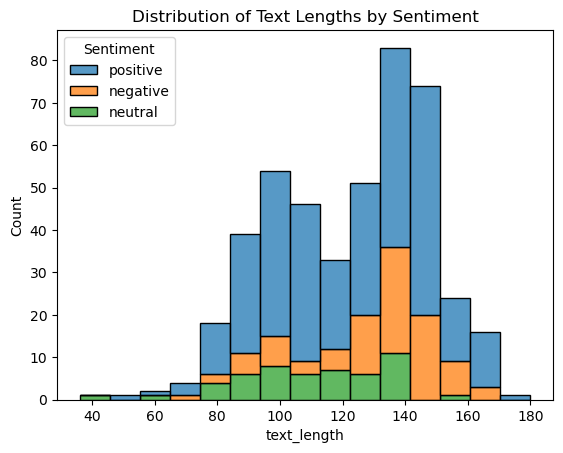

In [77]:
sns.histplot(x='text_length', data=df, hue='Sentiment', multiple='stack')
plt.title('Distribution of Text Lengths by Sentiment')
plt.show()

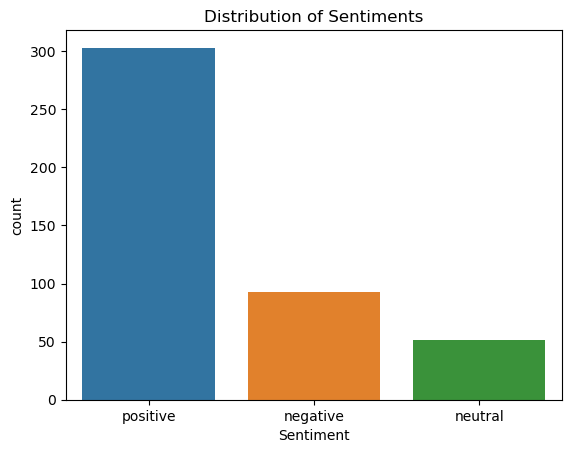

In [78]:
sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

In [79]:
# Posts with highest positive sentiment
df.loc[df['compound'].idxmax()].values

array([2018, 'Visa',
       "i love using my visa card. it's widely accepted and the rewards program is great.",
       81,
       list(['love', 'using', 'visa', 'card', 'widely', 'accepted', 'rewards', 'program', 'great']),
       'love using visa card widely accepted rewards program great',
       'love using visa card widely accepted rewards program great',
       'love using visa card widely accepted rewards program great', True,
       0.0, 0.27, 0.73, 0.926, 'positive'], dtype=object)

In [80]:
# Posts with highest negative sentiment 
df.loc[df['compound'].idxmin()].values

array([2016, 'Apple',
       "apple's macbook keyboards are a disaster. they're prone to failure, and the repair costs are outrageous. it's a design flaw that apple needs to address.",
       152,
       list(['apple', 'macbook', 'keyboards', 'disaster', 'prone', 'failure', 'repair', 'costs', 'outrageous', 'design', 'flaw', 'apple', 'needs', 'address']),
       'apple macbook keyboards disaster prone failure repair costs outrageous design flaw apple needs address',
       'apple macbook keyboards disaster prone failure repair costs outrageous design flaw apple needs address',
       'apple macbook keyboards disaster prone failure repair costs outrageous design flaw apple needs address',
       True, 0.486, 0.514, 0.0, -0.886, 'negative'], dtype=object)

## Vectorization

In [81]:
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.2, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[['Corpus_string_lem','Corpus_token', 'Company','Year']], 
                                                        df['Sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
positive    239
negative     76
neutral      42
Name: Sentiment, dtype: int64
Value counts for Test sentiments
positive    64
negative    17
neutral      9
Name: Sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                  Corpus_string_lem  \
0    390  apple restrictive repair policies nightmare ma...   
1     35  optimistic microsoft future microsoft stocks i...   
2     54  apple latest iphone release everyone talking m...   
3    295  abercrombie fitch overpriced clothes justify q...   
4    389  apple face unreliable often fails recognize fa...   

                                        Corpus_token              Company  \
0  [apple, restrictive, repair, policies, nightma...                Apple   
1  [optimistic, microsoft, future, microsoft, sto...            Microsoft   
2  [apple, latest, iphone, release, everyone, tal...                Apple   
3  [abercrombie, fi

In [82]:
print(X_test.head())

   index                                  Corpus_string_lem  \
0    181  palantir data analytics tools helped uncover v...   
1     40  bought google shares feeling optimistic future...   
2    407  apple commitment accessibility remarkable stri...   
3     21  invested amazon stocks happier company growth ...   
4    270  gucci fashion shows always feast eyes creative...   

                                        Corpus_token   Company  Year  
0  [palantir, data, analytics, tools, helped, us,...  Palantir  2017  
1  [bought, google, shares, feeling, optimistic, ...    Google  2016  
2  [apple, commitment, accessibility, remarkable,...     Apple  2022  
3  [invested, amazon, stocks, happier, company, g...    Amazon  2015  
4  [gucci, fashion, shows, always, feast, eyes, c...     Gucci  2019  


In [83]:
print(Y_train.head())

   index Sentiment
0    390  negative
1     35  positive
2     54   neutral
3    295  positive
4    389  positive


## Word2Vec Model Training

In [84]:
df.head(5)

,Year,Company,Corpus,text_length,Corpus_token,Corpus_string,Corpus_string_fdist,Corpus_string_lem,is_equal,neg,neu,pos,compound,Sentiment
0,2018,Amazon,i'm excited to see amazon's new headquarters i...,141,"[excited, see, amazon, new, headquarters, virg...",excited see amazon new headquarters virginia t...,excited see amazon new headquarters virginia t...,excited see amazon new headquarters virginia t...,True,0.000,0.618,0.382,0.7003,positive
1,2015,Apple,i'm so disappointed in apple's new product lin...,125,"[disappointed, apple, new, product, lineup, us...",disappointed apple new product lineup used inn...,disappointed apple new product lineup used inn...,disappointed apple new product lineup used inn...,True,0.221,0.571,0.207,-0.0516,negative
2,2017,Tesla,just bought some tesla stock and i'm feeling r...,139,"[bought, tesla, stock, feeling, really, good, ...",bought tesla stock feeling really good think e...,bought tesla stock feeling really good think e...,bought tesla stock feeling really good think e...,True,0.000,0.553,0.447,0.7960,positive
3,2019,Netflix,just finished binge-watching the latest netfli...,114,"[finished, binge, watching, latest, netflix, s...",finished binge watching latest netflix series ...,finished binge watching latest netflix series ...,finished binge watching latest netflix series ...,True,0.000,0.593,0.407,0.5859,positive
4,2016,Facebook,i'm loving all the new features on facebook. i...,109,"[loving, new, features, facebook, great, way, ...",loving new features facebook great way stay co...,loving new features facebook great way stay co...,loving new features facebook great way stay co...,True,0.000,0.387,0.613,0.9022,positive


In [85]:
from gensim.models import Word2Vec

size_dim = 10 # Default number of dimensions of the embeddings. So no need to add separatley
window = 3 #Maximum distance between a target word and words around the target word
min_count = 3 #Minimum count of words considered while training the model, words with lesser occurence will be ignored
sg = 1 #for skip gram model = 1 and for  CBOW =0
review_stock_processed = pd.Series(df['Corpus_string_lem']).values

# Train the Word2Vec Model
w2v_model = Word2Vec(review_stock_processed,vector_size=30, min_count = min_count, workers = 4, window = window, sg = sg)

## Feature Extraction

In [86]:
# Store the vectors for train data in following file
OUTPUT_FOLDER=""


word2vec_filename = OUTPUT_FOLDER + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        # Taking average of vectors in a sentence. This will create an average array that captures the sentiment of the sentence
        model_vector = (np.mean([w2v_model.wv[token] for token in row['Corpus_string_lem'] if token in w2v_model.wv.key_to_index], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(30))
            word2vec_file.write(header)
            word2vec_file.write("\n")
            
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(30)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [87]:
# Load file in which features are stored
word2vec_df = pd.read_csv(r"train_review_word2vec.csv")
word2vec_df=word2vec_df.fillna(0)


In [88]:
word2vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.103466,0.052858,0.451459,-0.137642,-0.077624,-0.001710,0.098601,0.024841,-0.361083,-0.171453,...,0.196940,-0.083685,-0.140930,0.152715,0.147228,0.080705,0.194855,0.135183,-0.188474,-0.251449
1,-0.100647,0.047831,0.451466,-0.135814,-0.072011,0.000754,0.093607,0.033629,-0.356000,-0.165055,...,0.190254,-0.092648,-0.133309,0.163010,0.143502,0.074281,0.184929,0.133710,-0.189282,-0.263751
2,-0.099984,0.050766,0.454177,-0.135640,-0.078502,-0.003393,0.101297,0.025791,-0.360631,-0.174074,...,0.191969,-0.084741,-0.144880,0.153411,0.148799,0.070996,0.190608,0.133358,-0.186528,-0.258244
3,-0.104014,0.053060,0.449768,-0.137122,-0.073415,0.001054,0.099068,0.022698,-0.361335,-0.171408,...,0.195803,-0.092401,-0.143049,0.148801,0.143171,0.082505,0.200264,0.136863,-0.181753,-0.260532
4,-0.109901,0.058586,0.453931,-0.143947,-0.074721,-0.007433,0.099466,0.017152,-0.357853,-0.178316,...,0.193665,-0.081507,-0.148994,0.151340,0.151138,0.080757,0.198132,0.135015,-0.182704,-0.248258


## Model Training and Evaluation

In [89]:
#Initialize the model
clf_decision_word2vec_RFC = RandomForestClassifier(
n_estimators= 30,
 min_samples_split= 2,
 min_samples_leaf= 2,
 max_features= 'auto',
 max_depth= 12,
 criterion= 'entropy',
 bootstrap= True,
class_weight='balanced') 
start_time = time.time()
# Fit the model
word2vec_RFC = clf_decision_word2vec_RFC.fit(word2vec_df, Y_train['Sentiment'])
print("Time taken to fit the Random Forest Classifier model with word2vec vectors: " + str(time.time() - start_time))


#Initialize the Linear Regression model
clf_decision_word2vec_LR = LogisticRegression()
start_time = time.time()
# Fit the model
word2vec_LR = clf_decision_word2vec_LR.fit(word2vec_df, Y_train['Sentiment'])
print("Time taken to fit the Logistic Regression model with word2vec vectors: " + str(time.time() - start_time))

#Initialize the Decision Tree model
clf_decision_word2vec_DTC = DecisionTreeClassifier()
start_time = time.time()
# Fit the model
word2vec_DTC = clf_decision_word2vec_DTC.fit(word2vec_df, Y_train['Sentiment'])
print("Time taken to fit the Decision Tree Classifier model with word2vec vectors: " + str(time.time() - start_time))

#Initialize the KNeighborsClassifier model 
clf_decision_word2vec_KNC = KNeighborsClassifier()
start_time = time.time()
# Fit the model
word2vec_KNC = clf_decision_word2vec_KNC.fit(word2vec_df, Y_train['Sentiment'])
print("Time taken to fit the KNeighbors Classifier model with word2vec vectors: " + str(time.time() - start_time))


# Perform cross-validation
scores = cross_val_score(clf_decision_word2vec_RFC, word2vec_df, Y_train['Sentiment'], cv=5)
# Calculate the mean accuracy
accuracy_RFC = scores.mean()
print("Accuracy for RFC Model:", accuracy_RFC)

scores = cross_val_score(clf_decision_word2vec_LR, word2vec_df, Y_train['Sentiment'], cv=5)
# Calculate the mean accuracy
accuracy_LR = scores.mean()
print("Accuracy for Logistic Regression:", accuracy_LR)

scores = cross_val_score(clf_decision_word2vec_DTC, word2vec_df, Y_train['Sentiment'], cv=5)
# Calculate the mean accuracy
accuracy_DTC = scores.mean()
print("Accuracy for Decision Tree Classifier:", accuracy_DTC)

scores = cross_val_score(clf_decision_word2vec_KNC, word2vec_df, Y_train['Sentiment'], cv=5)
# Calculate the mean accuracy
accuracy_KNC = scores.mean()
print("Accuracy for KNeighbors Classifier :", accuracy_KNC)



Time taken to fit the Random Forest Classifier model with word2vec vectors: 0.04968714714050293
Time taken to fit the Logistic Regression model with word2vec vectors: 0.008192062377929688
Time taken to fit the Decision Tree Classifier model with word2vec vectors: 0.005421876907348633
Time taken to fit the KNeighbors Classifier model with word2vec vectors: 0.0007700920104980469
Accuracy for RFC Model: 0.6945226917057903
Accuracy for Logistic Regression: 0.6695226917057904
Accuracy for Decision Tree Classifier: 0.5491392801251956
Accuracy for KNeighbors Classifier : 0.5769953051643192


In [90]:
## Classification Report
train_features = []
for index, row in X_train.iterrows():
    vector = np.mean([w2v_model.wv[token] for token in row['Corpus_string_lem'] if token in w2v_model.wv.key_to_index], axis=0)
    if type(vector) is np.ndarray:
        train_features.append(vector)
    else:
        train_features.append(np.array([0 for i in range(30)]))

## RFC
train_predictions_RFC = clf_decision_word2vec_RFC.predict(train_features)
print("Classification report for the Random Forest Classifier Model :") 
print(classification_report(Y_train['Sentiment'],train_predictions_RFC))

## LR
train_predictions_LR = clf_decision_word2vec_LR.predict(train_features)
print("Classification report for the Logistic Regression Model :") 
print(classification_report(Y_train['Sentiment'],train_predictions_LR))

## KNC
train_predictions_KNC = clf_decision_word2vec_KNC.predict(train_features)
print("Classification report for the KNeighbors Classifier Model :") 
print(classification_report(Y_train['Sentiment'],train_predictions_KNC))

## DTC
train_predictions_DTC = clf_decision_word2vec_DTC.predict(train_features)
print("Classification report for the Decision Tree Classifier Model :") 
print(classification_report(Y_train['Sentiment'],train_predictions_DTC))


Classification report for the Random Forest Classifier Model :
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        76
     neutral       1.00      1.00      1.00        42
    positive       1.00      1.00      1.00       239

    accuracy                           1.00       357
   macro avg       1.00      1.00      1.00       357
weighted avg       1.00      1.00      1.00       357

Classification report for the Logistic Regression Model :
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        76
     neutral       0.00      0.00      0.00        42
    positive       0.67      1.00      0.80       239

    accuracy                           0.67       357
   macro avg       0.22      0.33      0.27       357
weighted avg       0.45      0.67      0.54       357

Classification report for the KNeighbors Classifier Model :
              precision    recall  f1-score   support

  

## Confusion Matrix Visualisation

          Negative  Positive  Neutral
Negative        76         0        0
Positive         0        42        0
Neutral          0         0      239


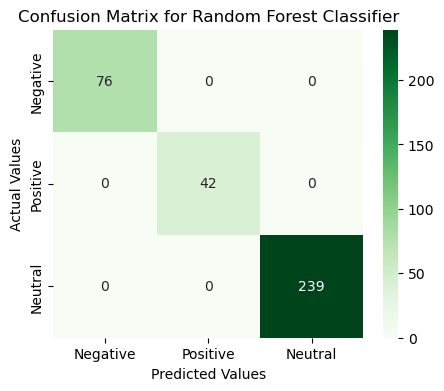

          Negative  Positive  Neutral
Negative         0         0       76
Positive         0         0       42
Neutral          0         0      239


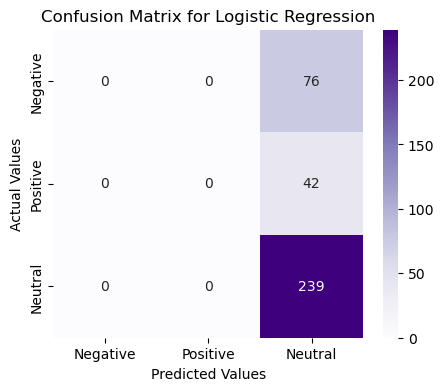

          Negative  Positive  Neutral
Negative        76         0        0
Positive         0        42        0
Neutral          0         0      239


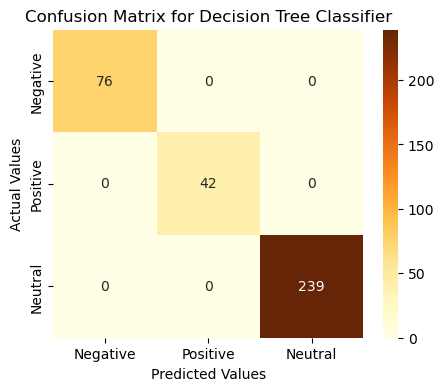

          Negative  Positive  Neutral
Negative        50         1       25
Positive        10        10       22
Neutral         32         7      200


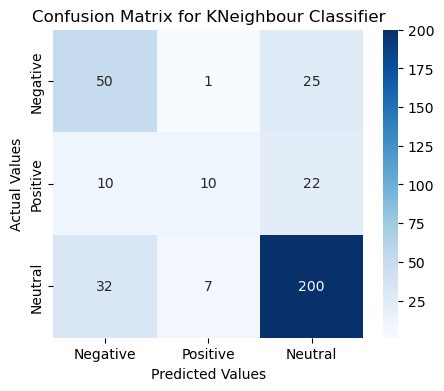

In [91]:
cm_RFC = confusion_matrix(Y_train['Sentiment'],train_predictions_RFC)
cm_df_RFC = pd.DataFrame(cm_RFC,
                     index = ['Negative','Positive', 'Neutral'], 
                     columns = ['Negative','Positive', 'Neutral'])
print(cm_df_RFC)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_RFC, annot=True,fmt='g',cmap='Greens')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

cm_LR = confusion_matrix(Y_train['Sentiment'],train_predictions_LR)
cm_df_LR = pd.DataFrame(cm_LR,
                     index = ['Negative','Positive', 'Neutral'], 
                     columns = ['Negative','Positive', 'Neutral'])
print(cm_df_LR)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_LR, annot=True,fmt='g',cmap='Purples')
plt.title('Confusion Matrix for Logistic Regression')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


cm_DTC = confusion_matrix(Y_train['Sentiment'],train_predictions_DTC)
cm_df_DTC = pd.DataFrame(cm_DTC,
                     index = ['Negative','Positive', 'Neutral'], 
                     columns = ['Negative','Positive', 'Neutral'])
print(cm_df_DTC)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_DTC, annot=True,fmt='g',cmap='YlOrBr')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

cm_KNC = confusion_matrix(Y_train['Sentiment'],train_predictions_KNC)
cm_df_KNC = pd.DataFrame(cm_KNC,
                     index = ['Negative','Positive', 'Neutral'], 
                     columns = ['Negative','Positive', 'Neutral'])
print(cm_df_KNC)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_KNC, annot=True,fmt='g',cmap='Blues')
plt.title('Confusion Matrix for KNeighbour Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Tests Data Predictions

In [92]:
test_features = []
for index, row in X_test.iterrows():
    vector = np.mean([w2v_model.wv[token] for token in row['Corpus_string_lem'] if token in w2v_model.wv.key_to_index], axis=0)
    if type(vector) is np.ndarray and vector.shape == (30,):  # Check if vector has the expected shape
        test_features.append(vector)
    else:
        test_features.append(np.zeros(30))  # Use zeros as a placeholder if vector shape is invalid
test_features = np.array(test_features)  # Convert test_features to a numpy array


test_predictions_RFC = clf_decision_word2vec_RFC.predict(test_features)
print("Classification report for the Random Forest Classifier Model :") 
print(classification_report(Y_test['Sentiment'], test_predictions_RFC))

test_predictions_DTC = clf_decision_word2vec_DTC.predict(test_features)
print("Classification report for the Decision Tree Classifier Model :") 
print(classification_report(Y_test['Sentiment'], test_predictions_DTC))

test_predictions_KNC = clf_decision_word2vec_KNC.predict(test_features)
print("Classification report for the KNeighbour Classifier Model :") 
print(classification_report(Y_test['Sentiment'], test_predictions_KNC))

test_predictions_LR = clf_decision_word2vec_LR.predict(test_features)
print("Classification report for the Logistic Regression :") 
print(classification_report(Y_test['Sentiment'], test_predictions_LR))

Classification report for the Random Forest Classifier Model :
              precision    recall  f1-score   support

    negative       0.80      0.24      0.36        17
     neutral       0.00      0.00      0.00         9
    positive       0.74      0.98      0.85        64

    accuracy                           0.74        90
   macro avg       0.51      0.41      0.40        90
weighted avg       0.68      0.74      0.67        90

Classification report for the Decision Tree Classifier Model :
              precision    recall  f1-score   support

    negative       0.29      0.29      0.29        17
     neutral       0.22      0.22      0.22         9
    positive       0.75      0.75      0.75        64

    accuracy                           0.61        90
   macro avg       0.42      0.42      0.42        90
weighted avg       0.61      0.61      0.61        90

Classification report for the KNeighbour Classifier Model :
              precision    recall  f1-score   suppor

<AxesSubplot:title={'center':'Sentiments for stocks on Apple'}>

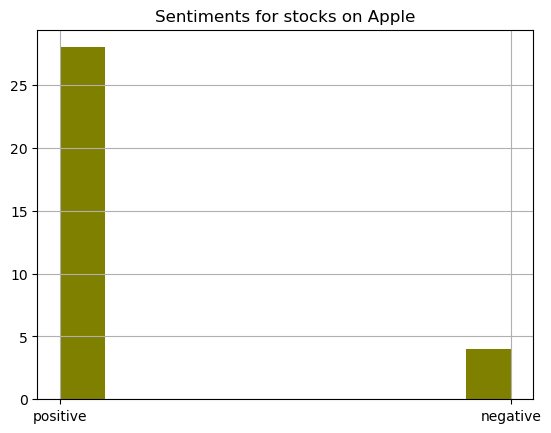

In [93]:
#Predictions from model
X_test['Sentiment Predicted']=test_predictions_RFC
temp1=X_test.loc[X_test['Company']=="Apple"].reset_index(drop=True)
plt.title('Sentiments for stocks on Apple')
temp1['Sentiment Predicted'].hist(color = 'olive') 

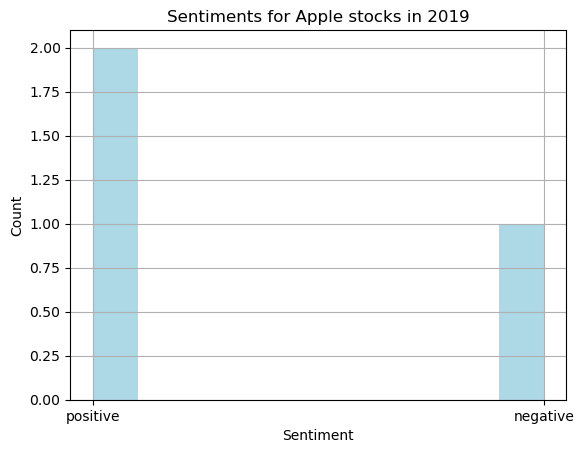

In [94]:
X_test['Sentiment Predicted'] = test_predictions_RFC
temp2 = X_test.loc[(X_test['Company'] == "Apple") & (X_test['Year'] == 2019)].reset_index(drop=True)
temp2['Sentiment Predicted'].hist(color = 'lightblue')
plt.title('Sentiments for Apple stocks in 2019')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

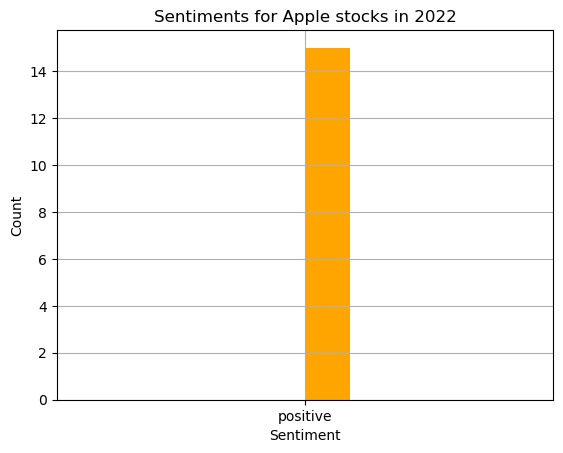

In [95]:
X_test['Sentiment Predicted'] = test_predictions_RFC
temp3 = X_test.loc[(X_test['Company'] == "Apple") & (X_test['Year'] == 2022)].reset_index(drop=True)
temp3['Sentiment Predicted'].hist(color = 'orange')
plt.title('Sentiments for Apple stocks in 2022')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

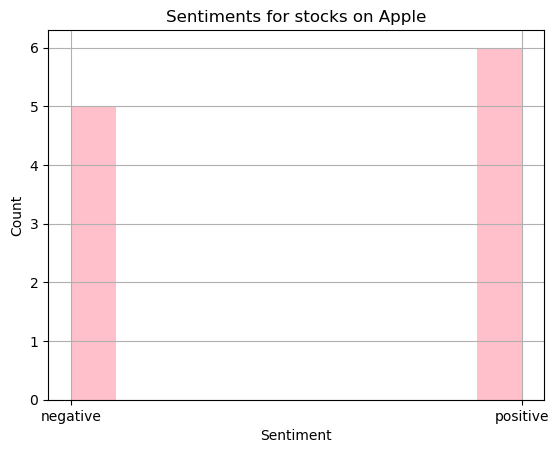

In [96]:
X_test['Sentiment Predicted'] = test_predictions_DTC
temp4 = X_test.loc[(X_test['Company'] == "Apple") & (X_test['Year'] )].reset_index(drop=True)
temp4['Sentiment Predicted'].hist(color = 'pink')
plt.title('Sentiments for stocks on Apple')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

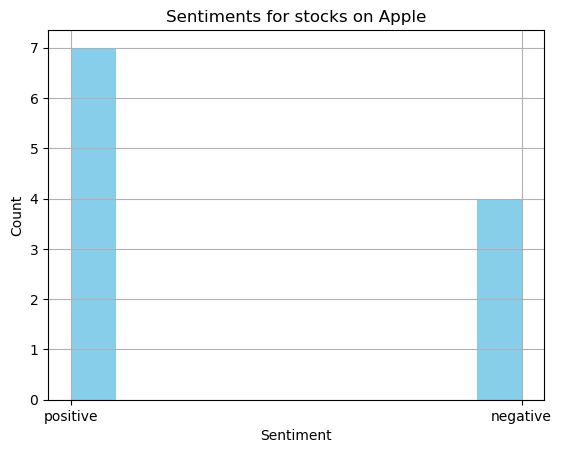

In [97]:
X_test['Sentiment Predicted'] = test_predictions_KNC
temp5 = X_test.loc[(X_test['Company'] == "Apple") & (X_test['Year'])].reset_index(drop=True)
temp5['Sentiment Predicted'].hist(color = 'skyblue')
plt.title('Sentiments for stocks on Apple')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

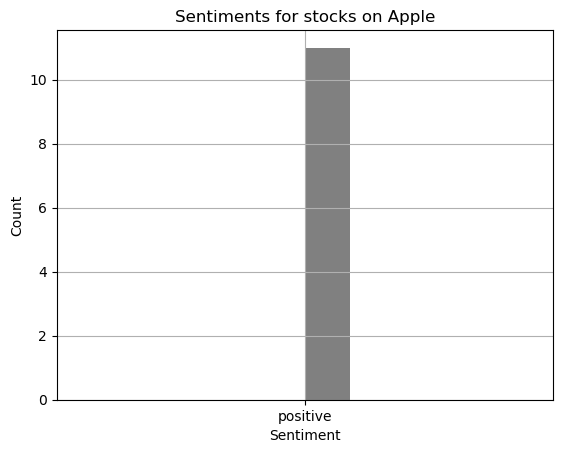

In [98]:
X_test['Sentiment Predicted'] = test_predictions_LR
temp6 = X_test.loc[(X_test['Company'] == "Apple") & (X_test['Year'])].reset_index(drop=True)
temp6['Sentiment Predicted'].hist(color = 'grey')
plt.title('Sentiments for stocks on Apple')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()